<h1>Land Feature CNN</h1>

Code and network framework gathered from:
https://www.tensorflow.org/tutorials/images/cnn

Authors:
- Thao Pham
- Lawrence Hoerst


In [1]:
import theCropper
theCropper.main()

Cropping training raw images successful
Cropping testing raw images successful
Cropping validation colored images successful
Finished all cropping


In [2]:
import theScaler
theScaler.main()

Scaling dimensions set to (100, 100)
Scaled the training images
Scaled the testing images
Scaled the colored testing images
Scaled the colored training images
Finished all scaling


In [3]:
import converter
# This will load the colored images into np arrays and pickle them
converter.main()

starting the conversion process
Training colored images converted successfully...
Validation colored images converted successfully...
Training input images converted successfully...
Validation input images converted successfully...
Finished all conversions


In [4]:
# Import tensorflow for the model
import tensorflow as tf
from tensorflow.keras import layers, models
# Import matplotlib to show retults
import matplotlib.pyplot as plt
# Import from PIL
from PIL import Image
from PIL import ImageColor
# Import pickle to read in training data
import pickle
# Import os to work with filepaths
import os

In [5]:
# Class names to plot the images:
class_names = ['Water', 'Buildings', 'Roads', 'Foliage', 'Mineral deposits', 'Mountainous terrain', 'Rocky terrain', 'Sandy terrain', 'Plains', 'Snow', 'Grass']
class_colors = ['#0f5e9c', ('#f2f2f2', '#606060'), '#c4c4c4', '#3a5f0b', '#490e0e', '#5a7a4c', '#698287', '#f7ae64', '#c89e23', '#fffafa', '#7cfc00']
class_codes = {class_names[i]: i for i in range(len(class_names))}

# hex_to_rgb
cvt = lambda hex: ImageColor.getcolor(hex, "RGB")
colors_to_code = {cvt('#0f5e9c'): 0,
                  cvt('#f2f2f2'): 1, cvt('#606060'): 1,
                  cvt('#c4c4c4'): 2,
                  cvt('#3a5f0b'): 3,
                  cvt('#490e0e'): 4,
                  cvt('#5a7a4c'): 5,
                  cvt('#698287'): 6,
                  cvt('#f7ae64'): 7,
                  cvt('#c89e23'): 8,
                  cvt('#fffafa'): 9,
                  cvt('#7cfc00'): 10,
                  'default':      11}

In [6]:
# Instantiate the model
model = models.Sequential()
# Add layers
# We need to decide on how many layers we want
# These parameters are not yet setup for our network
model.add(layers.InputLayer(shape=(*theScaler.scalingDimensions, 4)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(theScaler.scalingDimensions[0] * theScaler.scalingDimensions[1], activation='relu'))
model.add(layers.Dense(theScaler.scalingDimensions[0] * theScaler.scalingDimensions[1]))
model.add(layers.Reshape((*theScaler.scalingDimensions, 1))) # Make output in the same shape as a classification image
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28224)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10000)               │     282,250,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10000)               │     100,010,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 100, 100, 1)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 382,316,608 (1.42 GB)

 Trainable params: 382,316,608 (1.42 GB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
# unpickle our test data here
cwd = lambda fileName: os.path.join(os.getcwd(), fileName)
with open(cwd('training_inputs.pickle'), 'rb') as inputsFile:
    training_inputs = pickle.load(inputsFile)
with open(cwd('training_outputs.pickle'), 'rb') as outputsFile:
    training_outputs = pickle.load(outputsFile)

# unpickle the validation / testing outputs
with open(cwd('validation_inputs.pickle'), 'rb') as inputsFile:
    validation_inputs = pickle.load(inputsFile)
with open(cwd('validation_outputs.pickle'), 'rb') as outputsFile:
    validation_outputs = pickle.load(outputsFile)
    


In [13]:
# Train the model
history = model.fit(training_inputs, training_outputs, epochs=100, validation_data=(validation_inputs, validation_outputs))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/100
2/2 ━━━━

Epoch 48/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 50/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 52/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 54/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/100


Epoch 95/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 96/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 97/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 98/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 99/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 100/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


1/1 - 0s - 140ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


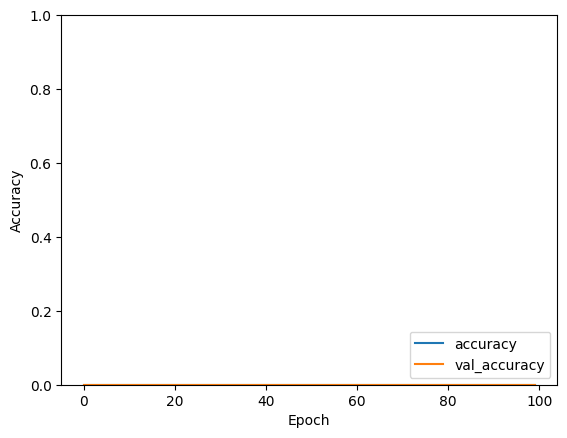

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(validation_inputs,  validation_outputs, verbose=2)